In [1]:
%load_ext autoreload
%autoreload 2
import sys
import keras
from keras.models import Model
from keras.layers import Conv2D, UpSampling2D
sys.path.insert(0, "../")
from scripts.alpha_matting.load_encoder_decoder import build_encoder_decoder_from_vgg
# from data_generator import DataGenerator
from scripts.alpha_matting.losses import overall_loss_wrapper
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.utils import multi_gpu_model
from keras.models import load_model
from keras.layers import Input
import numpy as np
from scripts.unpooling import Unpooling
from matplotlib.pyplot import imshow, figure
from model import build_encoder_decoder, build_refinement
import cv2 as cv
import math
import tensorflow as tf
from scipy import misc

Using TensorFlow backend.


In [88]:
keras.__version__

'2.2.0'

In [10]:
model = load_model("C:\\Workspace\\ThesisImageMatting\\model_checkpoints\\encoder_decoder.07-val_loss-0.1294-val_sad-187.0877-val_mse-0.0446.hdf5", custom_objects={"Unpooling": Unpooling()})

C:\Users\thalv\Anaconda3\envs\tensorflow-gpu\lib\site-packages\keras\engine\saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [7]:
image = cv.imread("D:\\Image Matting Dataset\\adobe dataset\\Combined_Dataset\\Test_set\\test_ds\\boy-1518482_1920_14.jpg")
trimap = cv.imread("D:\\Image Matting Dataset\\adobe dataset\\Combined_Dataset\\Test_set\\Adobe-licensed images\\trimaps\\boy-1518482_1920_14.png")

In [2]:
image = cv.imread("D:\\Image Matting Dataset\\adobe dataset\\Combined_Dataset\\Test_set\\test_ds\\beach-747750_1280_15.jpg")
trimap = cv.imread("C:\\Users\\thalv\\Desktop\\trimap_dog.jpg")

In [2]:
model_china = build_encoder_decoder()
final = build_refinement(model_china)
final.load_weights("C:\\Workspace\\ThesisImageMatting\\model_checkpoints\\final.42-0.0398.hdf5")


In [7]:
final.save("../model_checkpoints/refined.hdf5")

In [3]:
z = load_model("../model_checkpoints/refined.hdf5",custom_objects={"Unpooling": Unpooling()})

C:\Users\thalv\Anaconda3\envs\tensorflow-gpu\lib\site-packages\keras\engine\saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [5]:
final.weights

[<tf.Variable 'conv1_1/kernel:0' shape=(3, 3, 4, 64) dtype=float32_ref>,
 <tf.Variable 'conv1_1/bias:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'conv1_2/kernel:0' shape=(3, 3, 64, 64) dtype=float32_ref>,
 <tf.Variable 'conv1_2/bias:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'conv2_1/kernel:0' shape=(3, 3, 64, 128) dtype=float32_ref>,
 <tf.Variable 'conv2_1/bias:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'conv2_2/kernel:0' shape=(3, 3, 128, 128) dtype=float32_ref>,
 <tf.Variable 'conv2_2/bias:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'conv3_1/kernel:0' shape=(3, 3, 128, 256) dtype=float32_ref>,
 <tf.Variable 'conv3_1/bias:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'conv3_2/kernel:0' shape=(3, 3, 256, 256) dtype=float32_ref>,
 <tf.Variable 'conv3_2/bias:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'conv3_3/kernel:0' shape=(3, 3, 256, 256) dtype=float32_ref>,
 <tf.Variable 'conv3_3/bias:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'conv4_1/kerne

In [13]:
z_w = z.get_weights()

In [12]:
f_w = final.get_weights()

In [17]:
all([np.array_equal(z_w[i], f_w[i]) for i in range(84)])

True

In [5]:
model_refined = load_model("C:\\Workspace\\ThesisImageMatting\\model_checkpoints\\refinement.01-val_loss-0.2849-val_sad-202.5479-val_mse-0.1174.hdf5", custom_objects={"Unpooling": Unpooling()})

In [9]:
z = np.empty((300, 400))
w, h = z.shape[:2]
g = np.empty((w, h))
g.shape

(300, 400)

In [15]:
def pad_smaller_images(patch):
    w, h = patch.shape[:2]
    output = np.zeros((320, 320, 3))
    output[0:w, 0:h, :] = patch
    return output

In [14]:
def get_all_patches(image, trimap):
    '''
        Split the image in patches of 320x320px, predict an alpha matte for every one of them
    '''
    w, h = image.shape[:2]
    n_steps_w = math.ceil(w / 320)
    n_steps_h = math.ceil(h / 320)
    output = np.empty((n_steps_w * n_steps_h, 320, 320, 4))
    global_counter = 0
    for i in range(n_steps_w):
        for j in range(n_steps_h):
            patch_image = image[i * 320 : np.min([w, (i + 1) * 320]), j * 320: np.min([h, (j + 1) * 320]), :]
            patch_trimap = trimap[i * 320 : np.min([w, (i + 1) * 320]), j * 320: np.min([h, (j + 1) * 320]), :]
            
            if patch_image.shape != (320, 320, 3):
                print(patch_image.shape)
                patch_image = pad_smaller_images(patch_image)
                patch_trimap = pad_smaller_images(patch_trimap)
                print(patch_image.shape)

            
            patch_image = patch_image.reshape(1, 320, 320, 3)
            patch_trimap = patch_trimap[:, :, 0].reshape(1, 320, 320, 1)
            
            output[global_counter, :, :, 0:3] = patch_image / 255
            output[global_counter, :, :, 3:4] = patch_trimap / 255
            global_counter += 1
    return output, image.shape

In [13]:
def combine_patches(patches, original_shape):
    output = np.empty(original_shape)
    w, h = original_shape[:2]
    n_steps_w = math.ceil(w / 320)
    n_steps_h = math.ceil(h / 320)
    
    global_counter = 0
    for i in range(n_steps_w):
        for j in range(n_steps_h):
            patch = patches[global_counter][:, :, 0:len(original_shape)]
            global_counter += 1
            
            high_w = np.min([w, (i + 1) * 320]) - i * 320
            high_h =  np.min([h, (j + 1) * 320]) - j * 320
            output[i * 320 : np.min([w, (i + 1) * 320]), j * 320: np.min([h, (j + 1) * 320]), :] = patch[0:high_w, 0:high_h, 0:3]
    return output
            

In [8]:
out, shape = get_all_patches(image, trimap)

In [9]:
comb = combine_patches(out, shape)

In [11]:
alphas = []
for patch in out:
    alphas.append(final.predict(patch.reshape(1, 320, 320, 4)))

In [13]:
len(alphas)

24

In [12]:
comb_alpha = combine_patches(np.array(alphas).reshape(16, 320, 320, 1), (1268, 1280, 1)) 

ValueError: cannot reshape array of size 2457600 into shape (16,320,320,1)

In [15]:
shape

(1280, 1920, 3)

In [8]:
def get_final_output(out, trimap):
    mask = np.equal(trimap, 128/255).astype(np.float32)
    return (1 - mask) * trimap + mask * out

In [7]:
def get_alpha_for_whole_photo(image, trimap, model):
    out, shape = get_all_patches(image, trimap)
    alphas = []
    for patch in out:
        alphas.append(model.predict(patch.reshape(1, 320, 320, 4)))
    n_alphas = len(alphas)
    comb_alpha = combine_patches(np.array(alphas).reshape(n_alphas, 320, 320, 1), (shape[0], shape[1], 1)) 
    return get_final_output(comb_alpha.reshape(shape[0], shape[1]), trimap[: ,:, 0] / 255)

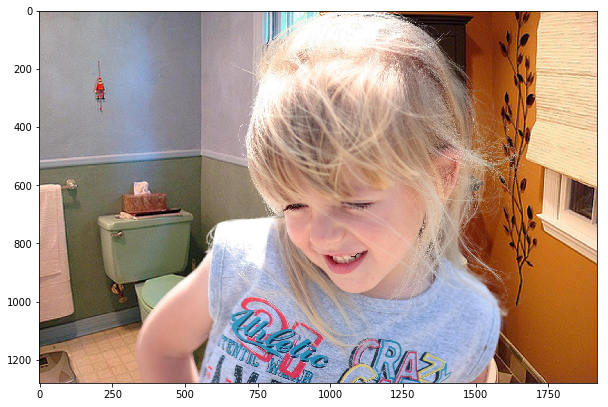

In [34]:
figure(figsize = (10,10))
imshow(cv.cvtColor((comb*255).astype(np.uint8), cv.COLOR_BGR2RGB))

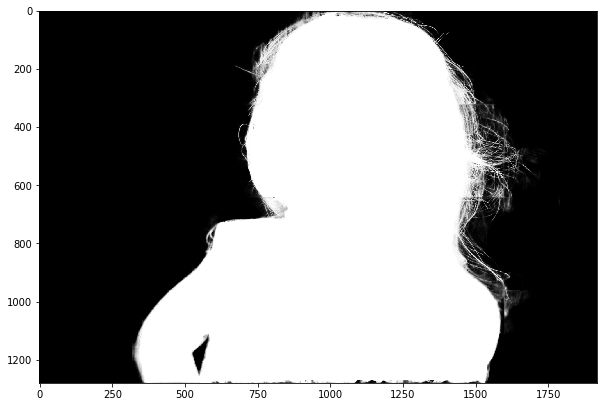

In [25]:
figure(figsize = (10,10))
imshow(get_alpha_for_whole_photo(image, trimap, model), cmap="gray")

In [30]:
x= cv.imread("D:\\Image Matting Dataset\\adobe dataset\\Combined_Dataset\\Test_set\\alpha\\boy-1518482_1920.png")

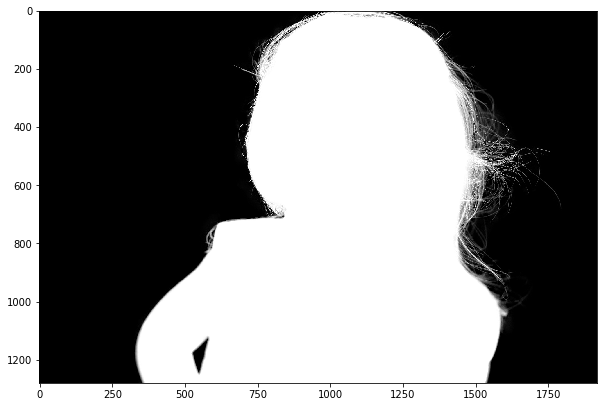

In [33]:
figure(figsize = (10,10))
imshow(cv.imread("D:\\Image Matting Dataset\\adobe dataset\\Combined_Dataset\\Test_set\\alpha\\boy-1518482_1920.png"), cmap="gray")

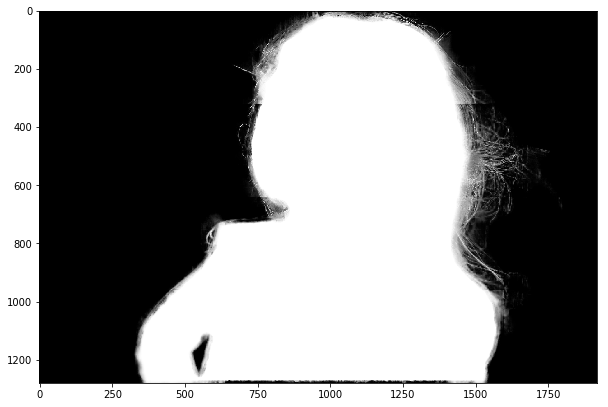

In [26]:
figure(figsize = (10,10))
imshow(get_alpha_for_whole_photo(image, trimap, final), cmap="gray")

In [11]:
img2 = cv.imread("D:\\Image Matting Dataset\\adobe dataset\\Combined_Dataset\\Test_set\\test_ds\\sieve-641426_1920_7.jpg")
trimap_2 = cv.imread("D:\\Image Matting Dataset\\adobe dataset\\Combined_Dataset\\Test_set\\Adobe-licensed images\\trimaps\\sieve-641426_1920_7.png")
gt_2 = cv.imread("D:\\Image Matting Dataset\\adobe dataset\\Combined_Dataset\\Test_set\\Adobe-licensed images\\alpha\\sieve-641426_1920.png")

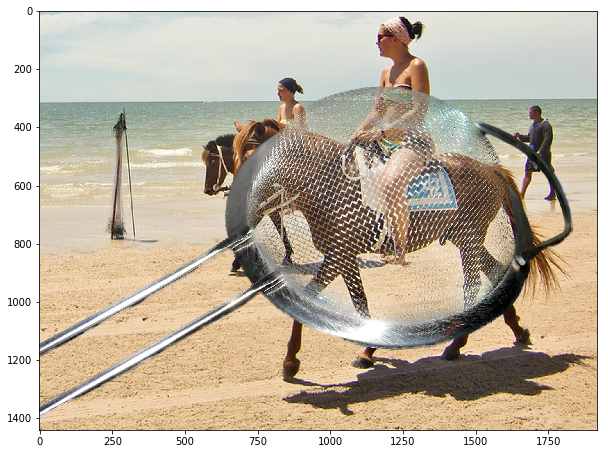

In [54]:
figure(figsize = (10,10))
imshow(cv.cvtColor((img2).astype(np.uint8), cv.COLOR_BGR2RGB))

(161, 320, 3)
(320, 320, 3)
(161, 320, 3)
(320, 320, 3)
(161, 320, 3)
(320, 320, 3)
(161, 320, 3)
(320, 320, 3)
(161, 320, 3)
(320, 320, 3)
(161, 320, 3)
(320, 320, 3)


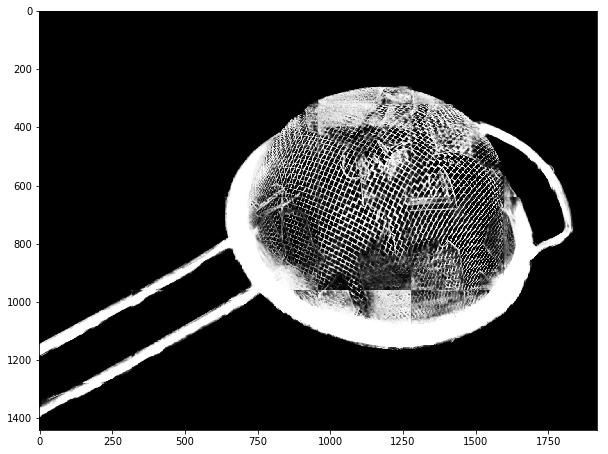

In [55]:
figure(figsize = (10,10))
imshow(get_alpha_for_whole_photo(img2, trimap_2, model), cmap="gray")

(161, 320, 3)
(320, 320, 3)
(161, 320, 3)
(320, 320, 3)
(161, 320, 3)
(320, 320, 3)
(161, 320, 3)
(320, 320, 3)
(161, 320, 3)
(320, 320, 3)
(161, 320, 3)
(320, 320, 3)


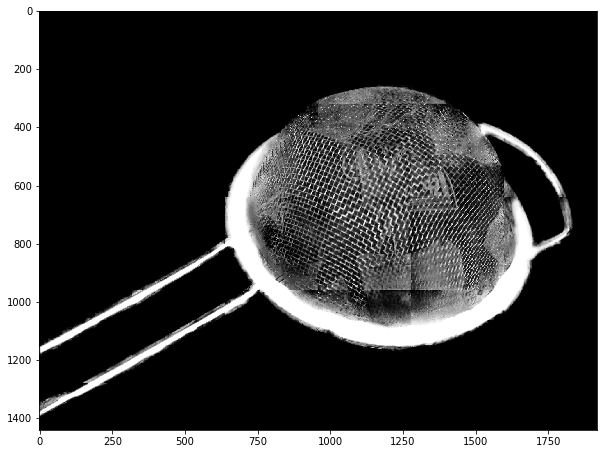

In [56]:
figure(figsize = (10,10))
imshow(get_alpha_for_whole_photo(img2, trimap_2, final), cmap="gray")

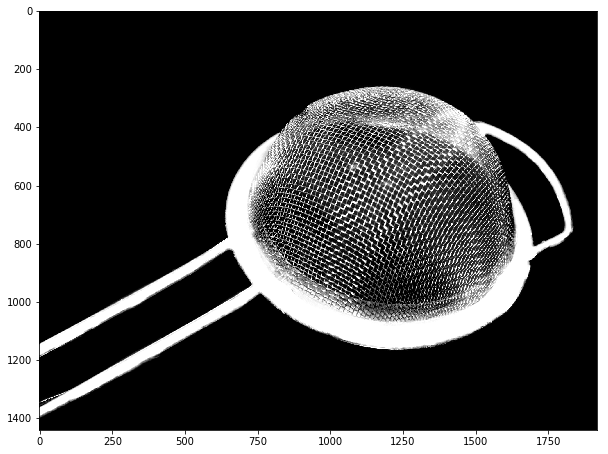

In [51]:
figure(figsize = (10,10))
imshow(gt_2, cmap="gray")

In [62]:
 output = np.empty((320, 320, 4))

In [29]:
def get_alpha_for_whole_photo_resized(image, trimap, model):
    input_for_nn = np.empty((320, 320, 4))
    img_small = cv.resize(image, (320, 320))
    trimap_small = cv.resize(trimap[:, :, 0], (320, 320))
    input_for_nn[:, :, 0:3] = img_small
    input_for_nn[:, :, 3] = trimap_small
    pred = model.predict(input_for_nn.reshape(1, 320, 320, 4))
    return get_final_output(pred.reshape(320, 320, 1), trimap_small.reshape(320, 320, 1) / 255)

In [36]:
img3 = cv.imread("D:\\Image Matting Dataset\\adobe dataset\\Combined_Dataset\\Test_set\\test_ds\\antique-honiton-lace-1182740_1920_15.jpg")
trimap_3 = cv.imread("D:\\Image Matting Dataset\\adobe dataset\\Combined_Dataset\\Test_set\\Adobe-licensed images\\trimaps\\antique-honiton-lace-1182740_1920_15.png")
gt_3 = cv.imread("D:\\Image Matting Dataset\\adobe dataset\\Combined_Dataset\\Training_set\\all_alphas\\GT04.jpg")


In [2]:
from trimap import generate_trimap

In [19]:
img4 = cv.imread("D:\\Image Matting Dataset\\merged_dataset\\GT04_63.png")
# trimap_4 = cv.imread("D:\\Image Matting Dataset\\adobe dataset\\Combined_Dataset\\Test_set\\Adobe-licensed images\\trimaps\\antique-honiton-lace-1182740_1920_15.png")
gt_4 = cv.imread("D:\\Image Matting Dataset\\adobe dataset\\Combined_Dataset\\Training_set\\all_alphas\\GT04.jpg")


In [35]:
trimap_4 = generate_trimap(gt_4)

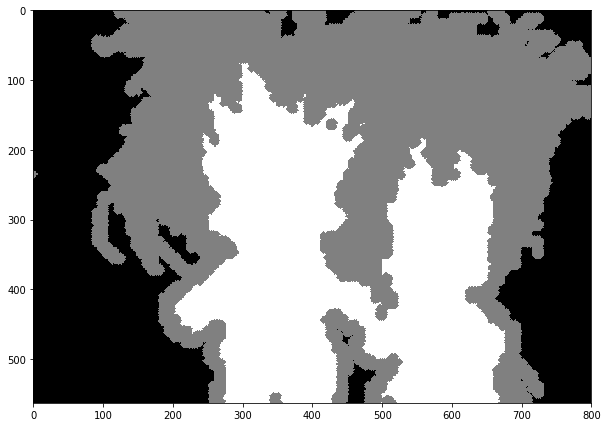

In [36]:
figure(figsize = (10,10))
imshow(trimap_4, cmap="gray")

In [22]:
trimap_4.shape

(563, 800, 3)

(320, 160, 3)
(320, 320, 3)
(243, 320, 3)
(320, 320, 3)
(243, 320, 3)
(320, 320, 3)
(243, 160, 3)
(320, 320, 3)


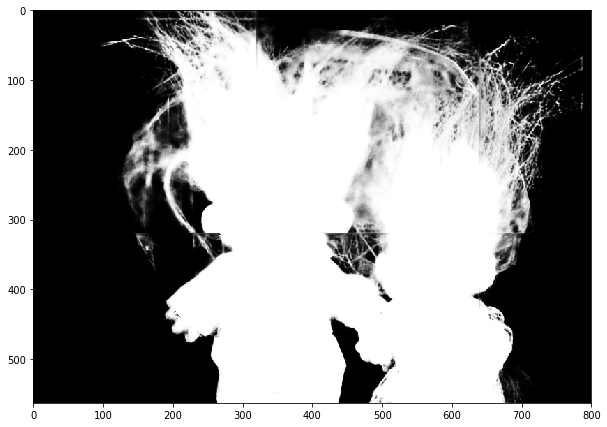

In [37]:
figure(figsize = (10,10))
imshow(get_alpha_for_whole_photo(img4, trimap_4, model), cmap="gray")

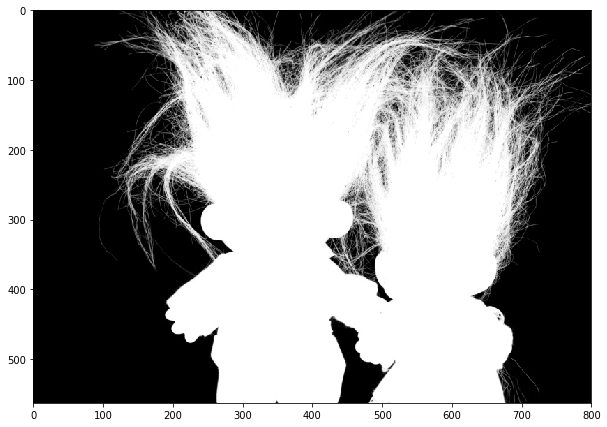

In [26]:
figure(figsize = (10,10))
imshow(gt_4, cmap="gray")

(320, 160, 3)
(320, 320, 3)
(243, 320, 3)
(320, 320, 3)
(243, 320, 3)
(320, 320, 3)
(243, 160, 3)
(320, 320, 3)


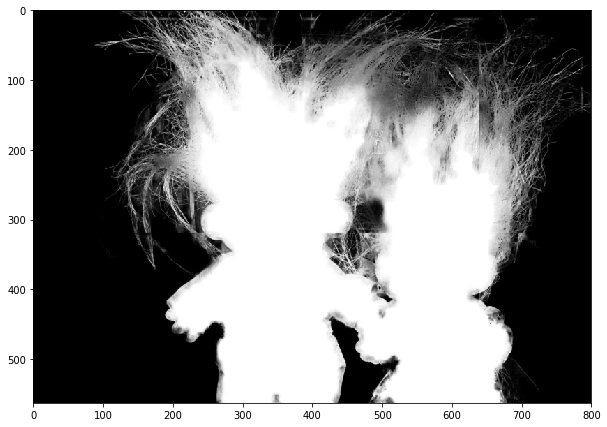

In [38]:
figure(figsize = (10,10))
imshow(get_alpha_for_whole_photo(img4, trimap_4, final), cmap="gray")

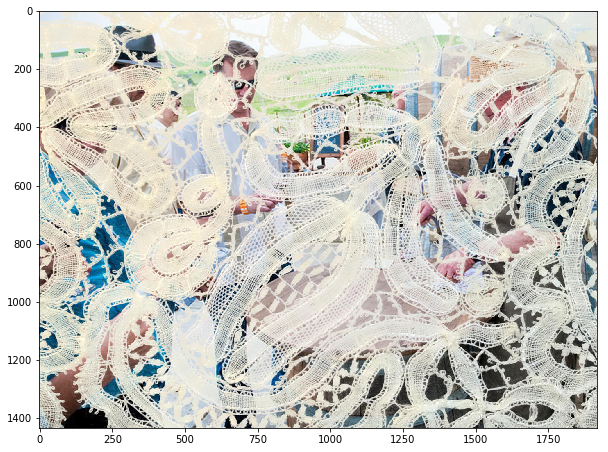

In [37]:
figure(figsize = (10,10))
imshow(cv.cvtColor((img3).astype(np.uint8), cv.COLOR_BGR2RGB))

(320, 320, 1)


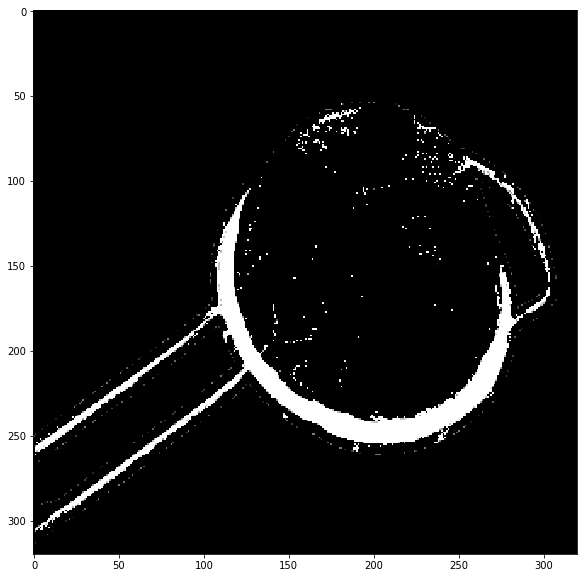

In [31]:
figure(figsize = (10,10))
o = get_alpha_for_whole_photo_resized(img2, trimap_2, final)
print(o.shape)
imshow(o.reshape(320, 320), cmap="gray")

(154, 320, 3)
(320, 320, 3)
(154, 320, 3)
(320, 320, 3)
(154, 320, 3)
(320, 320, 3)
(154, 320, 3)
(320, 320, 3)
(154, 320, 3)
(320, 320, 3)
(154, 320, 3)
(320, 320, 3)


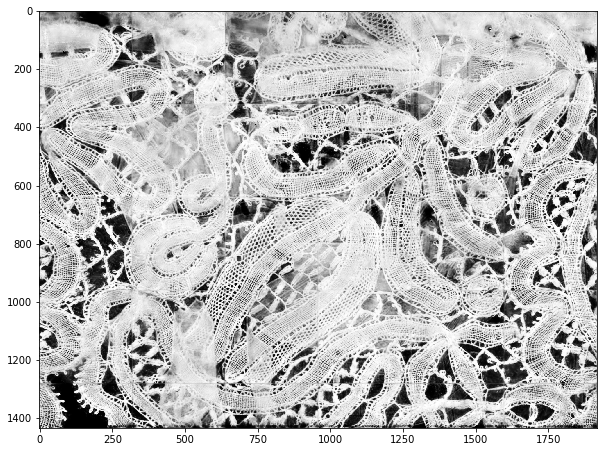

In [40]:
figure(figsize = (10,10))
imshow(get_alpha_for_whole_photo(img3, trimap_3, model), cmap="gray")

(154, 320, 3)
(320, 320, 3)
(154, 320, 3)
(320, 320, 3)
(154, 320, 3)
(320, 320, 3)
(154, 320, 3)
(320, 320, 3)
(154, 320, 3)
(320, 320, 3)
(154, 320, 3)
(320, 320, 3)


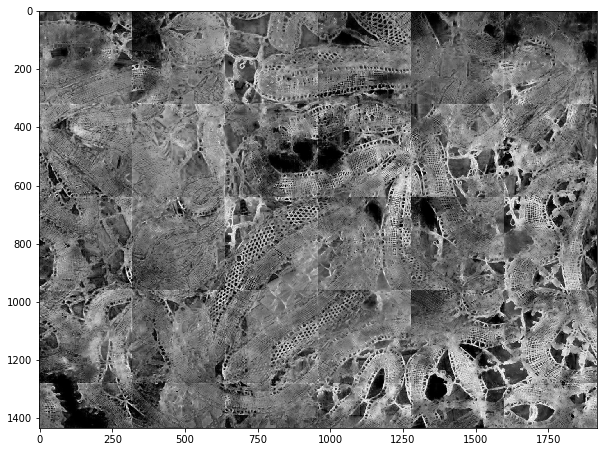

In [41]:
figure(figsize = (10,10))
imshow(get_alpha_for_whole_photo(img3, trimap_3, final), cmap="gray")

In [28]:
trimap[trimap[:, :, 0]<128] = 0
trimap[trimap[:, :, 0]>128] = 255

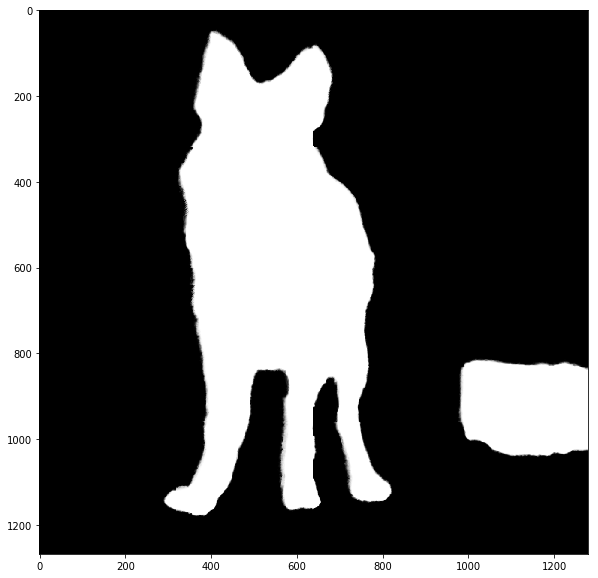

In [13]:
figure(figsize = (10,10))
imshow(get_final_output(comb_alpha.reshape(1268, 1280), trimap[:, :, 0]/255), cmap="gray")

In [21]:
from matplotlib.pyplot import imsave

In [23]:
imsave(r"C:\\Users\thalv\\Desktop\\output_alpha.jpg", get_final_output(comb_alpha.reshape(1268, 1280), trimap[:, :, 0]/255), cmap="gray")

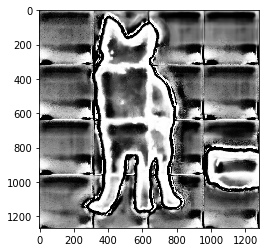

In [14]:
imshow(comb_alpha.reshape(1268, 1280), cmap="gray")

In [ ]:
imshow(cv.cvtColor((image3 * alpha.reshape(1280, 1920, 1)).astype(np.uint8), cv.COLOR_BGR2RGB))

In [33]:
alpha = get_final_output(comb_alpha.reshape(1280, 1920), trimap[:, :, 0]/255)

In [39]:
np.max(alpha)

1.0

In [43]:
np.max(image * alpha.reshape(1280, 1920, 1))

255.0

In [15]:
alpha = get_final_output(comb_alpha.reshape(1268, 1280), trimap[:, :, 0]/255)

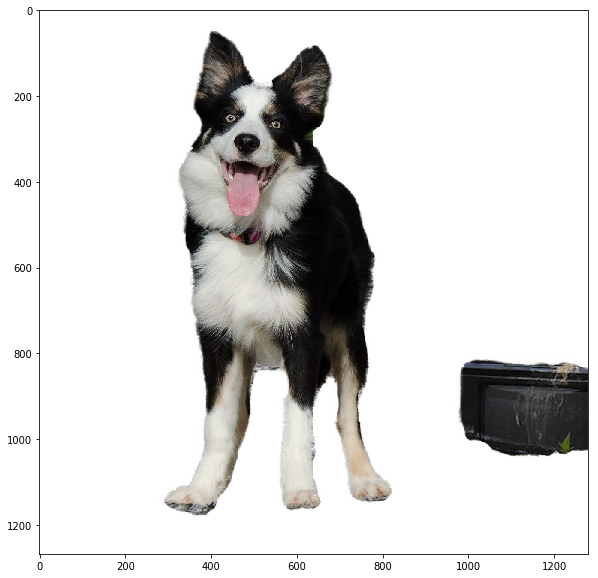

In [18]:
figure(figsize = (10,10))

imshow(cv.cvtColor((image * alpha.reshape(1268, 1280, 1) + (1 - alpha).reshape(1268, 1280, 1) * np.ones((1268, 1280, 3)) * 255).astype(np.uint8), cv.COLOR_BGR2RGB))

In [10]:
#PERSON

In [8]:
out, shape = get_all_patches(image, trimap)

(308, 320, 3)
(320, 320, 3)
(308, 320, 3)
(320, 320, 3)
(308, 320, 3)
(320, 320, 3)
(308, 320, 3)
(320, 320, 3)


In [ ]:
alphas = []
for patch in out:
    alphas.append(final.predict(patch.reshape(1, 320, 320, 4)))

In [ ]:
shape

In [18]:
comb_alpha = combine_patches(np.array(alphas).reshape(6, 320, 320, 1), (581, 777, 1)) 

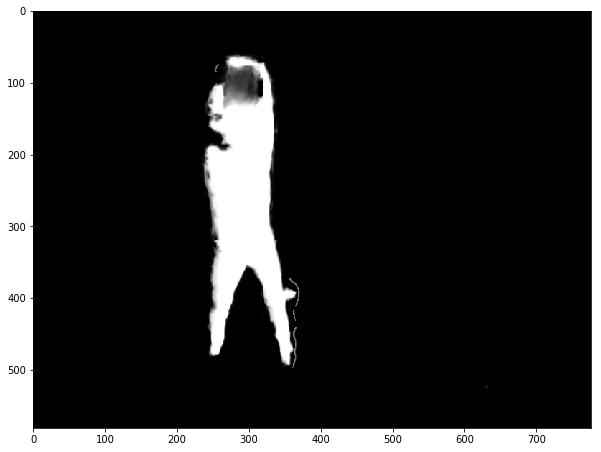

In [19]:
figure(figsize = (10,10))
imshow(get_final_output(comb_alpha.reshape(581, 777), trimap[:, :, 0]/255), cmap="gray")

In [23]:
alpha = get_final_output(comb_alpha.reshape(581, 777), trimap[:, :, 0]/255)

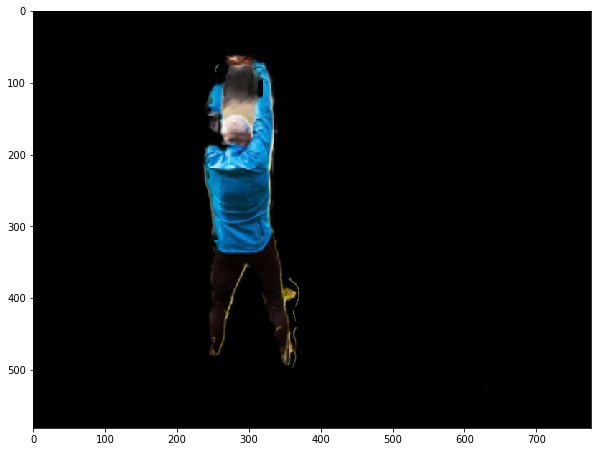

In [25]:
figure(figsize = (10,10))

imshow(cv.cvtColor((image * alpha.reshape(581, 777, 1)).astype(np.uint8), cv.COLOR_BGR2RGB))

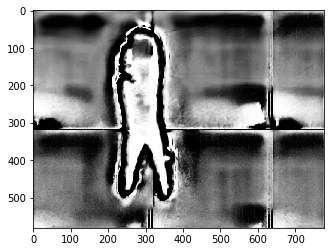

In [22]:
imshow(comb_alpha.reshape(581, 777), cmap="gray")

In [7]:
image_dog = cv.imread("D:\\Image Matting Dataset\\adobe dataset\\Combined_Dataset\\Test_set\\test_ds\\beach-747750_1280_2.jpg")
trimap_dog = cv.imread("D:\\Image Matting Dataset\\adobe dataset\\Combined_Dataset\\Test_set\\Adobe-licensed images\\trimaps\\beach-747750_1280_2.png")

In [8]:
out_dog, shape_dog = get_all_patches(image_dog, trimap_dog)

(308, 320, 3)
(320, 320, 3)
(308, 320, 3)
(320, 320, 3)
(308, 320, 3)
(320, 320, 3)
(308, 320, 3)
(320, 320, 3)


In [9]:
comb_dog = combine_patches(out_dog, shape_dog)

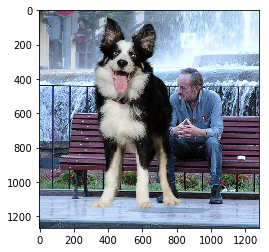

In [10]:
imshow(cv.cvtColor((comb_dog*255).astype(np.uint8), cv.COLOR_BGR2RGB))

In [17]:
alphas = []
for patch in out_dog:
    alphas.append(final.predict(patch.reshape(1, 320, 320, 4)))

In [76]:
image_dog.shape

(1268, 1280, 3)

In [18]:
comb_alpha_dog = combine_patches(np.array(alphas).reshape(16, 320, 320, 1), (1268, 1280, 1)) 

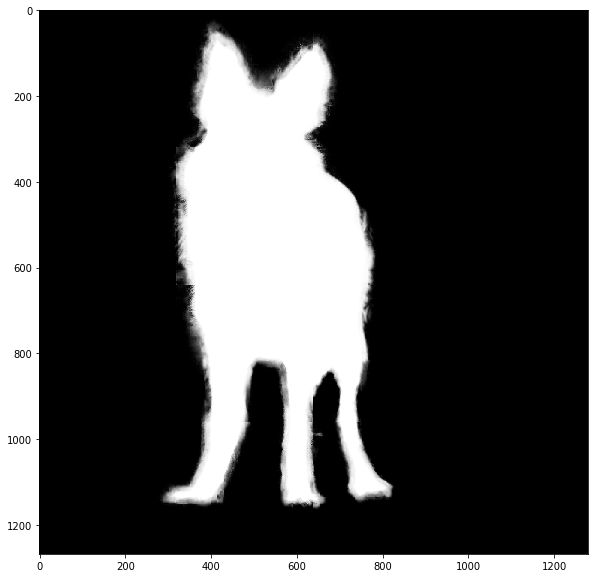

In [19]:
figure(figsize = (10,10))
imshow(get_final_output(comb_alpha_dog.reshape(1268, 1280), trimap_dog[:, :, 0]/255), cmap="gray")

In [20]:
alpha_dog = get_final_output(comb_alpha_dog.reshape(1268, 1280), trimap_dog[:, :, 0]/255)

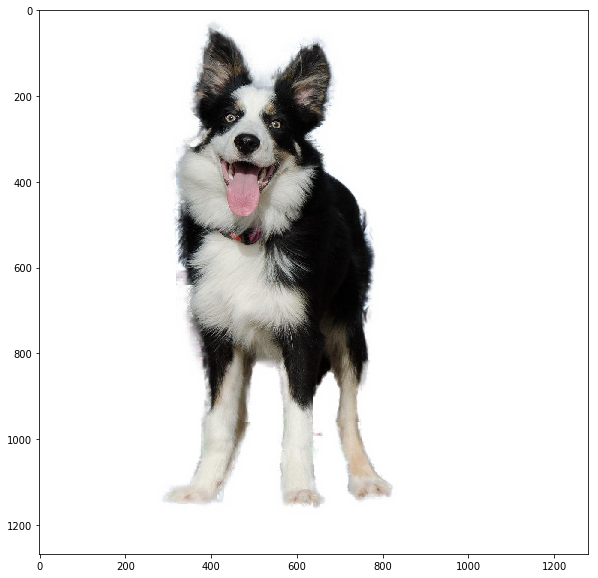

In [21]:
figure(figsize = (10,10))
imshow(cv.cvtColor((image_dog * alpha_dog.reshape(1268, 1280, 1) + (1 - alpha_dog).reshape(1268, 1280, 1) * np.ones((1268, 1280, 3)) * 255).astype(np.uint8), cv.COLOR_BGR2RGB))

In [2]:
def tryit(img_path):
    base = "C:\\Workspace\\SalienceModel\\Salient-Object-Detection\\"
    g_mean = np.array(([126.88,120.24,112.19])).reshape([1,1,3])

    config = tf.ConfigProto(
        device_count = {'GPU': 0}
    )
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction = 1)
    with tf.Session(config=tf.ConfigProto(gpu_options = gpu_options)) as sess:
        saver = tf.train.import_meta_graph(base + 'meta_graph\my-model.meta')
        saver.restore(sess,tf.train.latest_checkpoint(base + 'salience_model'))
        image_batch = tf.get_collection('image_batch')[0]
        pred_mattes = tf.get_collection('mask')[0]

        rgb = misc.imread(img_path)
        origin_shape = rgb.shape[:2]

        rgb = np.expand_dims(misc.imresize(rgb.astype(np.uint8),[320,320,3],interp="nearest").astype(np.float32)-g_mean,0)
        print(rgb.shape)
        feed_dict = {image_batch:rgb}
        pred_alpha = sess.run(pred_mattes,feed_dict = feed_dict)
        final_alpha = misc.imresize(np.squeeze(pred_alpha),origin_shape)
        return final_alpha


In [3]:
alpha = tryit("D:\\Image Matting Dataset\\adobe dataset\\Combined_Dataset\\Test_set\\test_ds\\boy-1518482_1920_14.jpg")

INFO:tensorflow:Restoring parameters from C:\Workspace\SalienceModel\Salient-Object-Detection\salience_model\model.ckpt-200


C:\Users\thalv\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  from ipykernel import kernelapp as app
C:\Users\thalv\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


(1, 320, 320, 3)


C:\Users\thalv\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:22: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


In [4]:
ret2,th2 = cv.threshold(alpha,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)

In [5]:
def trimap_gen(im):
    kernel_erosion = cv.getStructuringElement(cv.MORPH_ELLIPSE, (6, 6))
    kernel_dilation = cv.getStructuringElement(cv.MORPH_ELLIPSE, (4, 4))
    dilated = cv.dilate(im, kernel_dilation, iterations=10)
    eroded = cv.erode(im, kernel_erosion, iterations=20)
    unknown = dilated - eroded
    print(np.unique(eroded))
    return eroded + unknown * (128 / 255)

[  0 255]


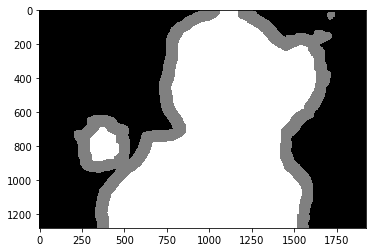

In [16]:
imshow(trimap_gen(th2), cmap="gray")

INFO:tensorflow:Restoring parameters from C:\Workspace\SalienceModel\Salient-Object-Detection\salience_model\model.ckpt-200


C:\Users\thalv\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  from ipykernel import kernelapp as app
C:\Users\thalv\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


(1, 320, 320, 3)
[  0 255]


C:\Users\thalv\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:22: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


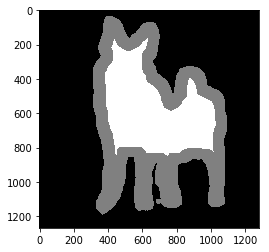

In [6]:
alpha = tryit("D:\\Image Matting Dataset\\adobe dataset\\Combined_Dataset\\Test_set\\test_ds\\beach-747750_1280_2.jpg")
ret2,th2 = cv.threshold(alpha,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
imshow(trimap_gen(th2), cmap="gray")

In [16]:
base_combined = "D:\\Image Matting Dataset\\adobe dataset\\Combined_Dataset\\Test_set\\test_ds_pascal_bg\\"
base_trimap = "D:\\Image Matting Dataset\\adobe dataset\\Combined_Dataset\\Test_set\\Adobe-licensed images\\trimaps\\"
base_alpha = "D:\\Image Matting Dataset\\adobe dataset\\Combined_Dataset\\Test_set\\alpha\\"

In [17]:
combined = cv.imread(base_combined + "16452523375_08591714cf_o_0.png")
alpha = cv.imread(base_alpha + "16452523375_08591714cf_o.png")
trimap = cv.imread(base_trimap + "16452523375_08591714cf_o_0.png")

In [20]:
trimap.shape

(2100, 1374, 3)

In [29]:
def prepare_input(comb, trimap):
    dimens = comb.shape
    dimens_new = (1, dimens[0], dimens[1], 4)
    container = np.empty(dimens_new)
    container[:, :, :, 0:3] = comb
    container[:, :, :, 3:4] = trimap[:, :, :1]
    return container

In [30]:
inp = prepare_input(combined, trimap)

In [38]:
def prepare_model(model):
    model.layers.pop(0)
    new_input = Input(shape=(None, None, 4))
    new_output = model(new_input)
    return Model(new_input, new_output)

In [6]:
PATIENCE=30
PATH_MODEL_CHECKPOINTS = "../model_checkpoints/"
PATH_LOGS = "../logs/"
BACKGROUNDS_PER_FG_TRAIN = 100
BACKGROUNDS_PER_FG_TEST = 20
BATCH_SIZE=16

In [14]:
fg_train = "D:\\Image Matting Dataset\\adobe dataset\\Combined_Dataset\\Training_set\\all_foregrounds\\"
bg_train = "D:\\Image Matting Dataset\\mscoco\\train2014\\train2014\\"
a_train = "D:\\Image Matting Dataset\\adobe dataset\\Combined_Dataset\\Training_set\\all_alphas\\"

fg_names_train = "D:\\Image Matting Dataset\\adobe dataset\\Combined_Dataset\\Training_set\\training_fg_names.txt"
bg_names_train = "D:\\Image Matting Dataset\\adobe dataset\\Combined_Dataset\\Training_set\\training_bg_names.txt"

combined_train = "D:\\Image Matting Dataset\\merged_dataset\\"


fg_test = "D:\\Image Matting Dataset\\adobe dataset\\Combined_Dataset\\Test_set\\Adobe-licensed images\\fg\\"
bg_test = "D:\\Image Matting Dataset\\mscoco\\test_selected\\"
a_test = "D:\\Image Matting Dataset\\adobe dataset\\Combined_Dataset\\Test_set\\Adobe-licensed images\\alpha\\"

fg_names_test = "D:\\Image Matting Dataset\\adobe dataset\\Combined_Dataset\\Test_set\\test_fg_names.txt"
bg_names_test = "D:\\Image Matting Dataset\\adobe dataset\\Combined_Dataset\\Test_set\\test_bg_names.txt"

combined_test = "D:\\Image Matting Dataset\\adobe dataset\\Combined_Dataset\\Test_set\\test_ds_pascal_bg\\"

# test_gen = DataGenerator(path_combined_test, path_alphas_test, 16, False) 
train_gen = DataGenerator(fg_names_train, bg_names_train, BACKGROUNDS_PER_FG_TRAIN, fg_train, bg_train, a_train,  combined_train, BATCH_SIZE, False)
test_gen = DataGenerator(fg_names_test, bg_names_test, BACKGROUNDS_PER_FG_TEST, fg_test, bg_test, a_test, combined_test, BATCH_SIZE, False)

['035A4301.jpg', '035A4302.jpg', '035A4304.jpg', '035A4305.jpg', '035A4308.jpg', '035A4310.jpg', '035A4311.jpg', '035A4313.jpg', '035A4316.jpg', '035A4320.jpg']
['16452523375_08591714cf_o.png', 'antique-honiton-lace-1182740_1920.png', 'ball-597523_1920.png', 'beach-747750_1280.png', 'boy-1518482_1920.png', 'brandy-402572_1920.png', 'cat-1288531_1920.png', 'cobweb-morgentau-dew-dewdrop-52501.png', 'crystal-82296_1920.png', 'dandelion-1335575_1920.png']


In [39]:
new_model = prepare_model(model)

In [44]:
new_model_refined = prepare_model(model_refined)


NameError: name 'prepare_mode' is not defined

In [45]:
new_model_china = prepare_model(final)

In [154]:
test_batch_0 = test_gen[8]

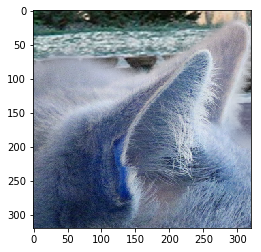

In [157]:
imshow(test_batch_0[0][2][:, :, 0:3], cmap="gray")

In [158]:
prediction_unrefined = model.predict(test_batch_0[0][2:3])
prediction_refined = model_refined.predict(test_batch_0[0][2:3])
prediction_china = final.predict(test_batch_0[0][2:3])

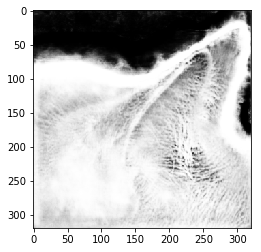

In [159]:
imshow(prediction_unrefined.reshape(320, 320), cmap="gray")

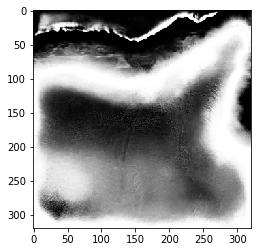

In [160]:
imshow(prediction_china.reshape(320, 320), cmap="gray")

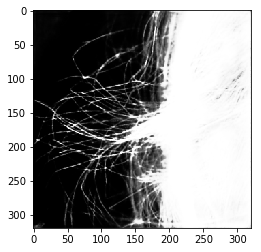

In [139]:
imshow(prediction_refined.reshape(320, 320), cmap="gray")

In [26]:
def get_final_output(out, trimap):
    mask = np.equal(trimap, 128/255).astype(np.float32)
    return (1 - mask) * trimap + mask * out


In [165]:
fin = get_final_output(prediction_unrefined, test_batch_0[0][2][:, :, 3:4])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


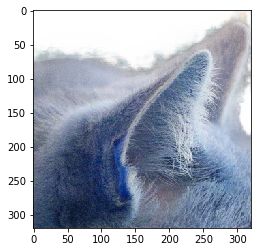

In [166]:
imshow((test_batch_0[0][2][ :, :, 0:3] * fin + (1-fin) * np.ones((320, 320, 3)) ).reshape(320, 320, 3))

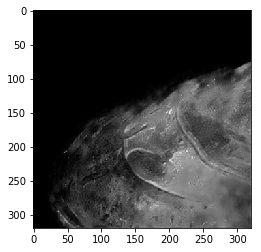

In [42]:
imshow(fin.reshape(320, 320), cmap="gray")

In [137]:
PATIENCE=30
PATH_MODEL_CHECKPOINTS = "../model_checkpoints/"
PATH_LOGS = "../logs/"
BACKGROUNDS_PER_FG_TRAIN = 100
BACKGROUNDS_PER_FG_TEST = 20
BATCH_SIZE=2

In [162]:
fg_train = "D:\\Image Matting Dataset\\adobe dataset\\Combined_Dataset\\Training_set\\all_foregrounds\\"
bg_train = "D:\\Image Matting Dataset\\mscoco\\train2014\\train2014\\"
a_train = "D:\\Image Matting Dataset\\adobe dataset\\Combined_Dataset\\Training_set\\all_alphas\\"

fg_names_train = "D:\\Image Matting Dataset\\adobe dataset\\Combined_Dataset\\Training_set\\training_fg_names.txt"
bg_names_train = "D:\\Image Matting Dataset\\adobe dataset\\Combined_Dataset\\Training_set\\training_bg_names.txt"


fg_test = "D:\\Image Matting Dataset\\adobe dataset\\Combined_Dataset\\Test_set\\Adobe-licensed images\\fg\\"
bg_test = "D:\\Image Matting Dataset\\mscoco\\test_selected\\"
a_test = "D:\\Image Matting Dataset\\adobe dataset\\Combined_Dataset\\Test_set\\Adobe-licensed images\\alpha\\"

fg_names_test = "D:\\Image Matting Dataset\\adobe dataset\\Combined_Dataset\\Test_set\\test_fg_names.txt"
bg_names_test = "D:\\Image Matting Dataset\\adobe dataset\\Combined_Dataset\\Test_set\\test_bg_names.txt"

# test_gen = DataGenerator(path_combined_test, path_alphas_test, 16, False) 
train_gen = DataGenerator(fg_names_train, bg_names_train, BACKGROUNDS_PER_FG_TRAIN, fg_train, bg_train, a_train, 16, False)
test_gen = DataGenerator(fg_names_test, bg_names_test, BACKGROUNDS_PER_FG_TEST, fg_test, bg_test, a_test, 16, False)

In [163]:
x = test_gen[0]
z = train_gen[0]

In [165]:
len(x[0])

16

In [28]:
x[0][1][:, :, 0:3].shape

(320, 320, 3)

In [168]:
prediction = model.predict(x[0][:1])

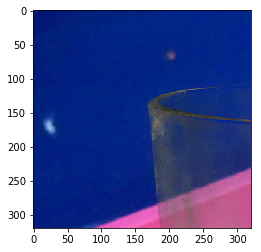

In [61]:
imshow(x[0][0][:, :, 0:3])

In [146]:
x[1][0].shape

(320, 320, 7)

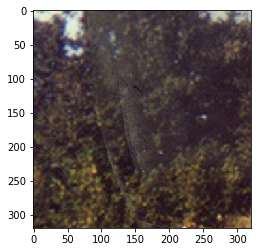

In [166]:
imshow(x[0][0][:,:,0:3])

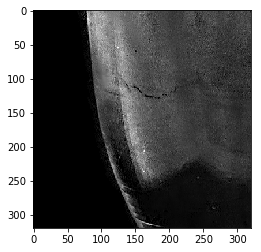

In [167]:
imshow(x[1][0][:, :, 0].reshape(320, 320), cmap="gray")

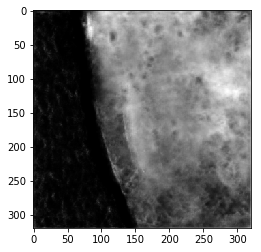

In [169]:
imshow(prediction.reshape(320, 320), cmap="gray")

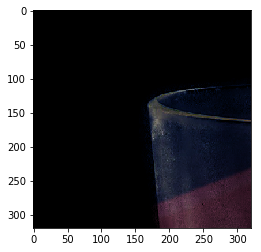

In [64]:
imshow(x[0][0][:, :, 0:3] * (x[1][0]))

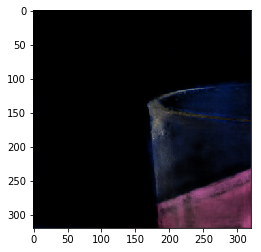

In [86]:
imshow(x[0][0][:, :, 0:3] * prediction[0])

# on train

In [49]:
pred_train = model.predict(z[0][:1])

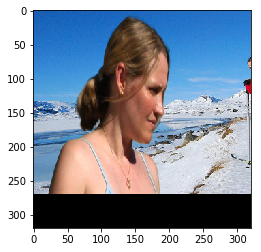

In [52]:
imshow(z[0][0][:, :, 0:3])

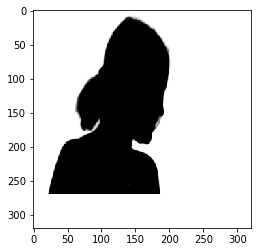

In [55]:
imshow(z[1][0].reshape(320, 320), cmap="Greys")

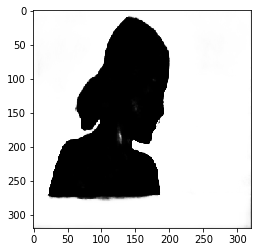

In [56]:
imshow(pred_train.reshape(320, 320), cmap="Greys")

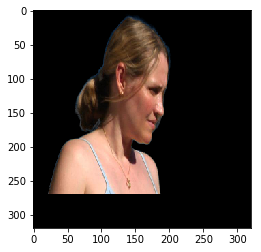

In [58]:
imshow(z[0][0][:, :, 0:3] * z[1][0])

In [65]:
from PIL import Image

In [107]:
comb = Image.open("D:\\Image Matting Dataset\\adobe dataset\\Combined_Dataset\\Test_set\\test_ds\\light-bulb-376930_1920_0.jpg")

In [109]:
comb.size

(1340, 1920)

In [111]:
import cv2 as cv
comb2 = cv.imread("D:\\Image Matting Dataset\\adobe dataset\\Combined_Dataset\\Test_set\\test_ds\\light-bulb-376930_1920_0.jpg")

In [112]:
comb2.shape

(1920, 1340, 3)

In [100]:
comb = np.array(comb)
alpha = np.array(Image.open("D:\\Image Matting Dataset\\adobe dataset\\Combined_Dataset\\Test_set\\alpha\\light-bulb-376930_1920.png"))

In [71]:
comb.shape

(2100, 1374, 3)

In [75]:
np.unique(alpha[:, :, 3])

array([255], dtype=uint8)

In [102]:
m = np.empty((1920,1340, 4))

In [103]:
m[:, :, 0:3] = comb
m[:, :, 3] = alpha[:, :, 0]

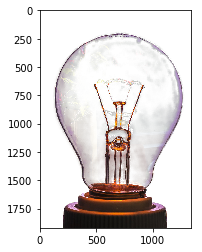

In [104]:
imshow(m/255)

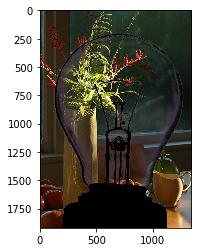

In [106]:
imshow(((comb / 255) * (1- alpha[:, :, :1] / 255)))

In [2]:
fg_train = "D:\\Image Matting Dataset\\adobe dataset\\Combined_Dataset\\Training_set\\all_foregrounds\\"
bg_train = "D:\\Image Matting Dataset\\mscoco\\train2014\\train2014\\"
a_train = "D:\\Image Matting Dataset\\adobe dataset\\Combined_Dataset\\Training_set\\all_alphas\\"

fg_names = "D:\\Image Matting Dataset\\adobe dataset\\Combined_Dataset\\Training_set\\training_fg_names.txt"
bg_names = "D:\\Image Matting Dataset\\adobe dataset\\Combined_Dataset\\Training_set\\training_bg_names.txt"

In [123]:
gen = DataGenerator(fg_names, bg_names, 100, fg_train, bg_train, a_train, 4, True)

In [124]:
x=gen[0]

134 452
452 530
472 78
276 824


In [129]:
x[1][0].shape

(320, 320, 7)

In [89]:
np.unique(x[2][0][1])

array([  0, 128, 255], dtype=uint8)

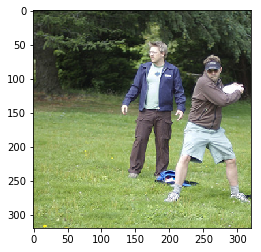

In [133]:
imshow(x[1][0][:, :, 4:7], cmap="gray")

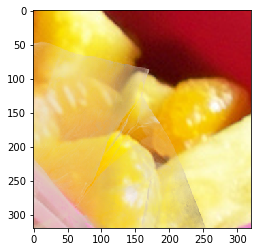

In [106]:
imshow(x[0][0][:, :, 0:3], cmap="gray")

In [113]:
128/255

0.5019607843137255

In [114]:
np.unique(x[0][0][:, :, 3] * 255)

array([  0., 128.], dtype=float32)

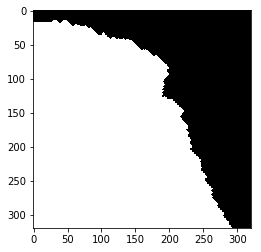

In [118]:
imshow((x[0][0][:, :, 3] * 255).astype(np.uint8), cmap="gray")

In [110]:
np.unique(x[2][0][1])

array([  0, 128, 255], dtype=uint8)

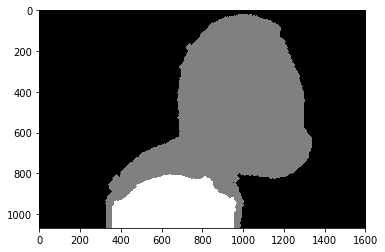

In [109]:
imshow(x[2][0][1], cmap="gray")

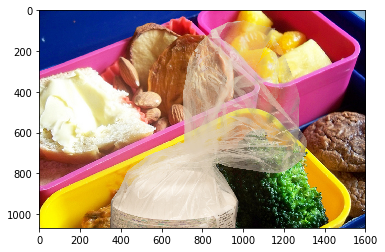

In [111]:
imshow(x[2][0][0], cmap="gray")

In [28]:
evth = x[0]

In [14]:
len(evth[0])

2

In [27]:
evth[0][3].shape

IndexError: tuple index out of range

In [30]:
evth[0][2].shape

(1067, 1600, 1)

In [39]:
evth[0][2].reshape(1067, 1600)[0, 0] * 255

0.0

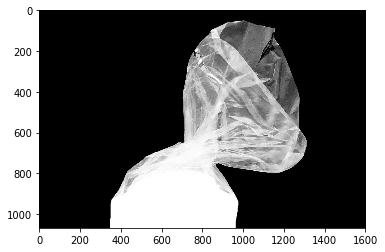

In [41]:
imshow(evth[0][2].reshape(1067, 1600), cmap="gray")

In [67]:
from trimap import generate_trimap
import numpy as np
trimap, fg, unknown, alpha = generate_trimap(evth[0][2].reshape(1067, 1600) * 255).astype(np.uint8))

In [68]:
trimap.shape

(1067, 1600)

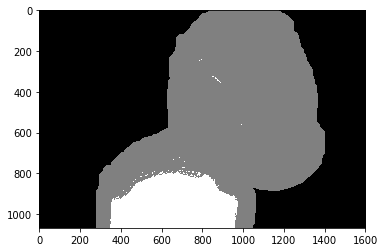

In [62]:
imshow(trimap, cmap="gray")

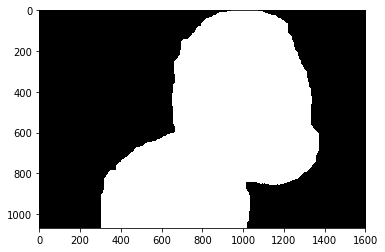

In [46]:
imshow(trimap, cmap="gray")

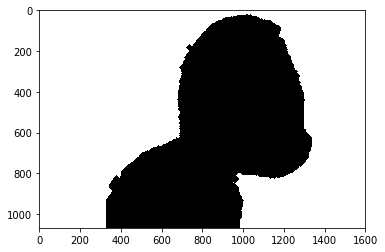

In [24]:
imshow(evth[0][1], cmap="Greys")

TypeError: Invalid dimensions for image data

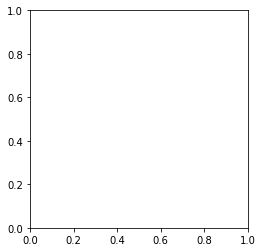

In [46]:
imshow(evth[0][])